<a href="https://colab.research.google.com/github/haribharadwaj/notebooks/blob/main/CSD2045/Generate_TB_ABR_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook creates tone-burst ABR waveforms for different stimulus levels and frequencies for a random infant case


This is still WIP.


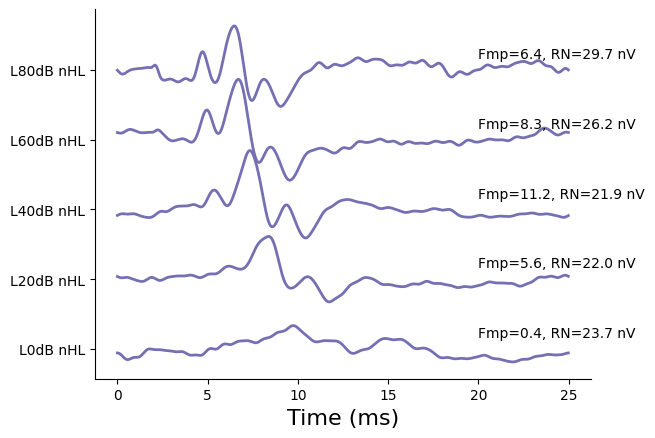

In [36]:
#@title This section generates the ABR data and plots results sorted by stimulus level (i.e., waterfall plots)
import numpy as np
import pylab as pl
from scipy.interpolate import interp1d

def getGorga1988Latency(L, f):
    # Ensure L and f are scalars
    if np.size(L) > 1 or np.size(f) > 1:
        raise ValueError("Level and frequency must be scalars in dB peSPL and kHz, respectively")

    Lref = np.array([20, 30, 40, 50, 60, 70, 80, 90, 100])
    aref = np.array([-0.230, -0.207, -0.219, -0.204, -0.177, -0.165, -0.157, -0.147, -0.139])
    bref = np.array([1.843, 1.727, 1.736, 1.652, 1.532, 1.462, 1.406, 1.356, 1.308])

    # Linear interpolation
    a = np.interp(L, Lref, aref)
    b = np.interp(L, Lref, bref)

    # Calculate tau
    tau = 10**(a * np.log10(f * 1e3) + b)

    return tau



def makeABR(a, l, t, f1=1, f3=1):
    a_ref = 0.33
    l_ref = 5.7

    # Wave V
    a1 = -9.372 * a / a_ref
    b1 = 6.659 * l / l_ref
    c1 = 1.038 * l / l_ref
    a2 = 7.301 * a / a_ref
    b2 = 6.885 * l / l_ref
    c2 = 0.901 * l / l_ref
    a3 = 3.745 * a / a_ref
    b3 = 6.096 * l / l_ref
    c3 = 0.8479 * l / l_ref

    # Wave III
    a4 = 0.15 * a * f3 / a_ref
    b4 = 4.2 * (l / l_ref)
    c4 = 0.35 * (l / l_ref)

    # Wave I
    a5 = 0.7 * 0.1913 * a * f1 / a_ref
    b5 = 1.9 * l / l_ref
    c5 = 0.1755 * l / l_ref
    a6 = -0.1073 * 0.7 * a * f1 / a_ref
    b6 = 2.3 * l / l_ref
    c6 = 0.4 * l / l_ref
    a7 = 0.06 * 0.7 * a * f1 / a_ref
    b7 = 1.5 * l / l_ref
    c7 = 0.2997 * l / l_ref

    # Make ABR
    x = (a1 * np.exp(-((t - b1) / c1) ** 2) +
         a2 * np.exp(-((t - b2) / c2) ** 2) +
         a3 * np.exp(-((t - b3) / c3) ** 2) +
         1.25 * a4 * np.exp(-((t - b4) / c4) ** 2) -
         a4 * 0.25 * np.exp(-((t - b4) / (4. * c4)) ** 2) +
         a5 * np.exp(-((t - b5) / c5) ** 2) +
         a6 * np.exp(-((t - b6) / c6) ** 2) +
         a7 * np.exp(-((t - b7) / c7) ** 2))

    return x




def w5amp(L, f):
    y_start=0.05
    k=0.1
    L0=45
    f_ref = np.array([0.5, 1, 2, 4, 8])
    scale_ref = np.array([0.15, 0.2, 0.22, 0.27, 0.21])
    # Create cubic spline interpolation function
    cubic_spline = interp1d(f_ref, scale_ref, kind='cubic')
    scale = cubic_spline(f)
    y =  scale / (1 + np.exp(-k * (L - L0)))
    return y


def w1amp(L, f):
  # Anchors
  L_end = 90
  y_end = 0.2
  L_start = 20
  # Assume a growth rate k
  k = 0.05
  # Calculate C to satisfy the condition y=0.2 at x=90
  C = y_end / (np.exp(k * (L_end - L_start)) - 1)
  # Define the exponential growth function

  f_ref = np.array([0.5, 1, 2, 4, 8])
  scale_ref = np.array([0.1, 0.14, 0.18, 0.24, 0.21])
  # Create cubic spline interpolation function
  cubic_spline = interp1d(f_ref, scale_ref, kind='cubic')
  scale = cubic_spline(f)
  return scale * C * (np.exp(k * (L - L_start)) - 1)


def getnHL(Lspl, f):
  # Use typical RETSPLs for ER3s to get nHL from peSPL
  RETSPL = np.array([25, 23, 28, 30])
  fref = np.array([0.5, 1, 2, 4])
  cubic_spline = interp1d(fref, RETSPL, kind='cubic')
  RETSPLf = cubic_spline(f)
  LnHL = Lspl - RETSPLf
  return LnHL


def getSNRwin(f):
  fref = np.array([0.5, 1, 2, 4])
  startref = np.array([6.5, 3.5, 2.5, 1.5])
  cubic_spline = interp1d(fref, startref, kind='cubic')
  start = cubic_spline(f)
  stop = start + 12
  return (start, stop)


def getpeSPL(LnHL, f):
  # Use typical RETSPLs for ER3s to get nHL from peSPL
  RETSPL = np.array([25, 23, 28, 30])
  fref = np.array([0.5, 1, 2, 4])
  cubic_spline = interp1d(fref, RETSPL, kind='cubic')
  RETSPLf = cubic_spline(f)
  LpeSPL = LnHL + RETSPLf
  return LpeSPL


def noise(N, fs, sigma, psd=lambda f: 1):
    """
    Generate noise with a given Power Spectral Density (PSD).

    Parameters:
    - N: Number of samples
    - fs: Sampling rate in Hz
    - sigma: Noise standar deviation for scaling
    - psd: A function that defines the desired PSD, accepting frequency in Hz.

    Returns:
    - A noise signal in the time domain.
    """
    X_white = np.fft.rfft(np.random.randn(N))
    freqs = np.fft.rfftfreq(N, d=1/fs)  # Using actual sampling rate
    S = psd(freqs)  # Apply PSD function to actual frequencies
    S = sigma * S / np.sqrt(np.mean(S**2))  # Normalize PSD
    X_shaped = X_white * S
    return np.fft.irfft(X_shaped, n=N)


# Make a decorator to call the  noise generation once we have a PSD
def PSDGenerator(f):
    return lambda N, fs, sigma: noise(N, fs, sigma, f)

# For TB ABR assume noise is pink between f_low = 30 Hz and f_high = 1500 Hz
@PSDGenerator
def abr_noise(f):
    f_low = 30
    f_high = 1500
    eps = np.finfo(float).eps
    f[f < eps] = eps
    return np.where((f > f_low) & (f < f_high), 1 / f, 0)



# Generate example
dur = 25e-3
fs = 48000
N = int(dur * fs)
t = np.arange(N) * 1e3 / fs  # milliseconds
sigma = 25e-3  # Microvolts
sigma_err = 10e-3

lcol = [117./255, 112./255, 179./255]
rcol = [217./255, 95./255, 2./255]




f = 4  # kHz

LnHL = np.arange(0, 100, 20)
LpeSPL = getpeSPL(LnHL, f)
n_levels = LpeSPL.shape[0]

start, stop = getSNRwin(f)

offset = 0.3

for k, L in enumerate(LpeSPL):
  RN = (np.random.rand() - 0.5) * sigma_err + sigma
  n = abr_noise(N, fs, RN)  # microvolts
  A5 = w5amp(L, f)
  lat = getGorga1988Latency(L, f)
  A1 = w1amp(L, f)
  A3 = (A5 + A1) / 2.0
  x = makeABR(A5, lat, t, f1=A1/0.4, f3=A3/0.2)  # Already in microvolts
  Fsp = (x[(t > start) & (t < stop)] ** 2).mean() / RN ** 2.
  pl.plot(t, n + x + k * offset, linewidth=2, color=lcol)
  pl.text(20, k*offset + 0.05, f'Fmp={Fsp:.1f}, RN={RN * 1e3:.1f} nV')


# Hide the top and right spines
pl.gca().spines['top'].set_visible(False)
pl.gca().spines['right'].set_visible(False)
pl.xlabel('Time (ms)', fontsize=16)
pl.yticks(ticks=np.arange(0, n_levels) * offset,
          labels=[f"L{value}dB nHL" for value in LnHL],
          fontsize=10)
pl.show()



